In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window_size = 960, base_threshold=0.2, volatility_window=96):
    """
    改进点：
    1. 根据市场波动率动态调整成交量阈值
    2. 高波动市场使用更严格的阈值（选取更少分钟作为聪明钱）
    3. 引入自适应机制应对极端行情
    """
    # 计算市场波动率（过去24小时ATR）
    high, low, close = df['high'].values, df['low'].values, df['close'].values
    atr = np.zeros(len(df))
    for i in range(1, len(df)):
        tr = max(high[i] - low[i], 
                 abs(high[i] - close[i-1]), 
                 abs(low[i] - close[i-1]))
        atr[i] = (atr[i-1] * (volatility_window-1) + tr) / volatility_window
    
    # 波动率归一化 (0-1范围)
    norm_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-7)
    
    # 动态阈值：高波动时降低阈值
    dynamic_threshold = base_threshold * (1 - norm_atr * 0.5)  # 波动率最大时阈值减半
    
    # 其余部分保持原始因子计算逻辑
    # ... [此处省略与原始因子相同的计算部分] ...
    # 预计算所有必要值
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    avg_price_vals = avg_price.values
    
    abs_ret = abs((df['close'] - df['open']) / df['open'])
    
    volume = df['volume'].values
        
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 预计算S值 (|R|/sqrt(V))
    S_values = abs_ret.values / np.sqrt(volume)
    
    # 使用滑动窗口计算
    for i in range(window_size, len(df)):
        # 获取当前窗口切片索引
        start_idx = i - window_size
        end_idx = i - 1
        
        # 提取当前窗口数据
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        window_S = S_values[start_idx:end_idx]
        
        # 按S值降序排序的索引
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 计算累积成交量
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        
        # 在计算中使用dynamic_threshold[i]替代固定阈值
        threshold = total_volume * dynamic_threshold[i]
        
        
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # 计算整体VWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # 计算因子值
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.011585
   Rank_IC (Spearman): 0.016998
📊 信息比率:
   IR: 0.308638
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130075
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


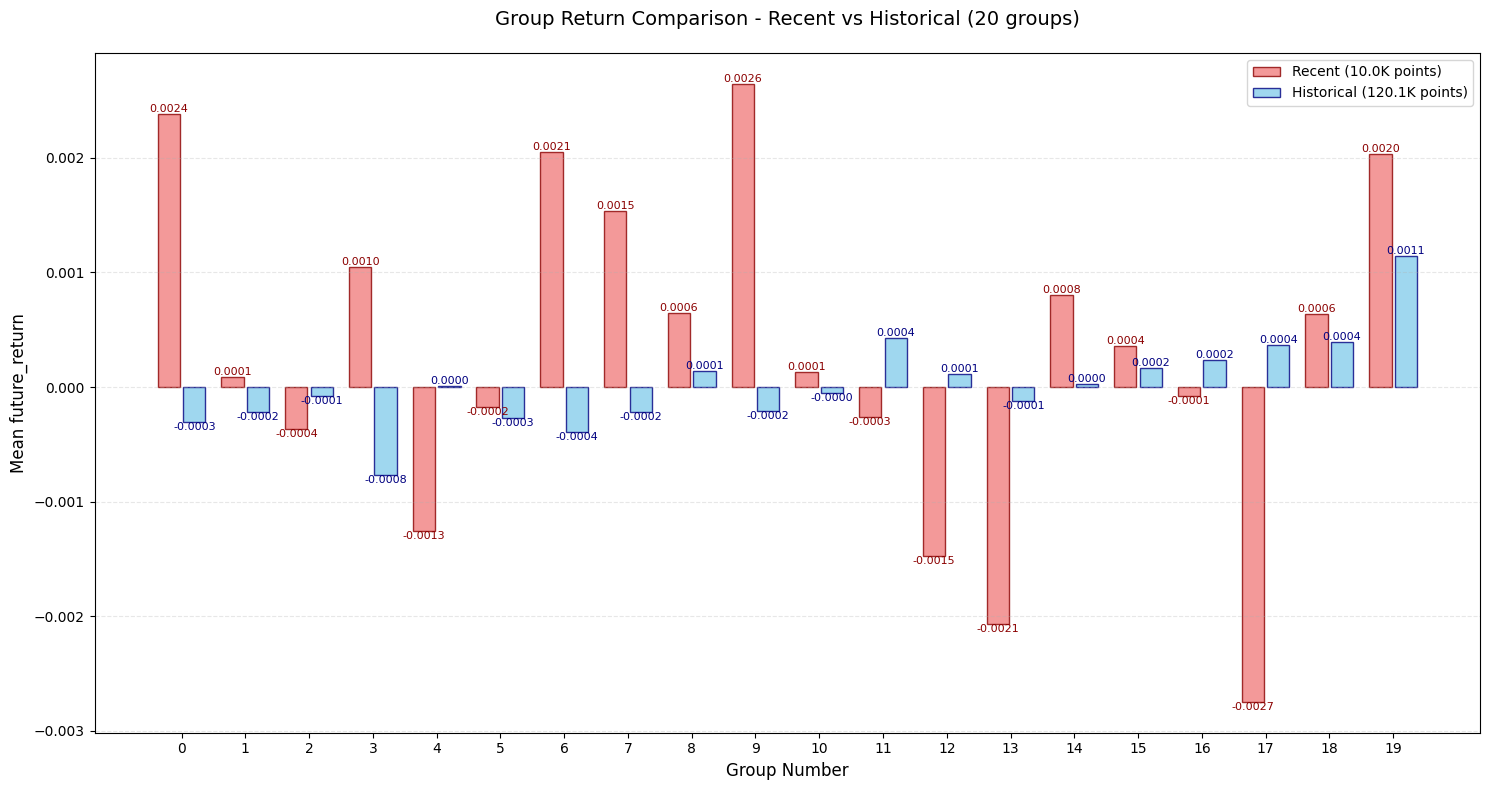

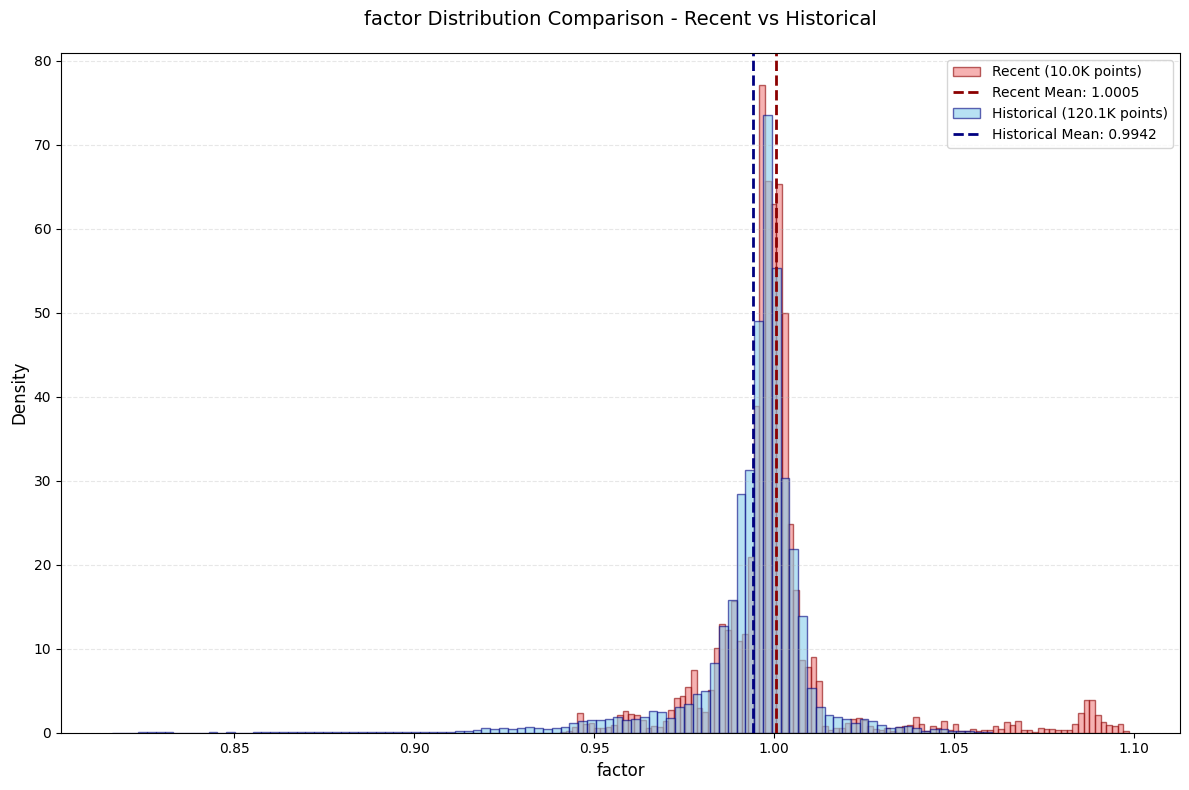

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

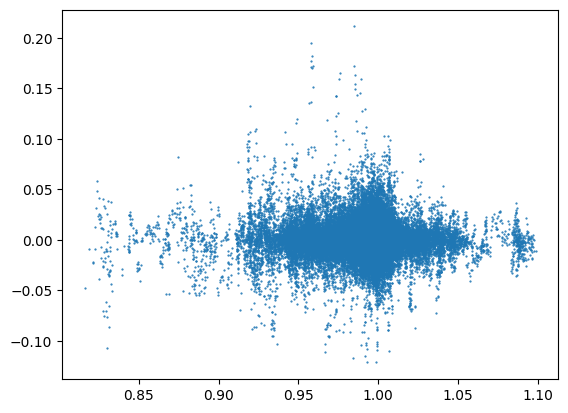

In [6]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.02899250291193383,
 0.004817499148662836,
 -0.0049578681989748,
 0.008137858301751141,
 -0.020749290976559278,
 0.04496137444110837,
 0.002873472158850747,
 0.028847798382216648,
 -0.004202092830986961,
 0.041347334910710305]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.011584681331798033, 'Rank_IC': 0.01699774571022494}, 'information_ratio': {'IR': 0.3086378234257829, 'group_correlations': [-0.02899250291193383, 0.004817499148662836, -0.0049578681989748, 0.008137858301751141, -0.020749290976559278, 0.04496137444110837, 0.002873472158850747, 0.028847798382216648, -0.004202092830986961, 0.041347334910710305], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.8159   0.9638    0.9406      -0.0003      0.0210   6504
1       0.9638   0.9806    0.9735       0.0000      0.0156   6504
2       0.9806   0.9863    0.9840      -0.0001      0.0130   6504
3       0.9863   0.9896    0.9882      -0.0007      0.0117   6503
4       0.9896   0.9915    0.9907      -0.0000      0.0113   6504
5       0.9915   0.9932    0.9924      -0.0002      0.0112   6504
6       0.9932   0.9947    0.9940      -0.